In [2]:
import xarray as xr
from saveCore_standalone_NFLICS import run_powerBlobs, powerBlob_utils, util
import ccores.cores as cores
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import os
from scipy.ndimage.measurements import label
from utils import constants as cnst

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
from utils import u_grid, u_interpolate as u_int
import glob

met_folder = cnst.ext_drive+'NFLICS/'
files = glob.glob(met_folder + 'IR_108_BT_20200905_2345.nc')
ds = xr.open_dataset(files[0], decode_times=False)

In [4]:
files

['/media/ck/LStorage/NFLICS/IR_108_BT_20200905_2345.nc']

In [29]:
data_resolution = 5 # in km
# make salem grid
grid5k = u_grid.make(np.arange(-19,0), np.arange(4,20), data_resolution*1000)
dlon = ds['lon_2d'].squeeze().values.T
dlat = ds['lat_2d'].squeeze().values.T
inds, weights, shape = u_int.interpolation_weights_grid(dlon, dlat, grid5k)

data = ds['IR108_BT'].squeeze().values.T
try:
    orig5k = u_int.interpolate_data(data, inds, weights, shape)
except IndexError:
    print('Interpolation problem, continue')
lon5k, lat5k = grid5k.ll_coordinates

ff = os.path.basename(files[0])
year = ff[10:14]
month = ff[14:16]
day = ff[16:18]
hour = ff[19:21]
minute = ff[21:23]


date = [datetime(int(year), int(month), int(day), int(hour), int(minute))]

In [30]:
data_resolution = 3 # in km
# make salem grid
grid3k = u_grid.make(np.arange(-19,0), np.arange(4,20), data_resolution*1000)
dlon = ds['lon_2d'].squeeze().values.T
dlat = ds['lat_2d'].squeeze().values.T
inds, weights, shape = u_int.interpolation_weights_grid(dlon, dlat, grid3k)

data = ds['IR108_BT'].squeeze().values.T
try:
    orig3k = u_int.interpolate_data(data, inds, weights, shape)
except IndexError:
    print('Interpolation problem, continue')
lon3k, lat3k = grid3k.ll_coordinates

ff = os.path.basename(files[0])
year = ff[10:14]
month = ff[14:16]
day = ff[16:18]
hour = ff[19:21]
minute = ff[21:23]


date = [datetime(int(year), int(month), int(day), int(hour), int(minute))]

In [31]:
regrid3k = grid3k.to_dataset()

In [32]:
regrid5k = grid5k.to_dataset()

In [33]:
outt, nogood, t_thresh_size, t_thresh_cut, pix_nb, area_img = powerBlob_utils.filter_img(orig5k, 5)
wav = util.waveletT(outt, dataset='METEOSAT5K_vera')
power_msg = powerBlob_utils.find_scales_dominant(wav, nogood, area_img, dataset='MSG')

outmin -86.93172091854575 24.458852846442632


In [34]:
old_nflics5k = xr.DataArray(power_msg, coords=[lat5k[:,0], lon5k[0,:]], dims=['lat', 'lon'])

In [35]:
old_nflics5k.name = 'power'

In [36]:
power_msg3k = regrid3k.salem.transform(old_nflics5k)

In [37]:
old_nflics3k = xr.DataArray(power_msg3k, coords=[lat3k[:,0], lon3k[0,:]], dims=['lat', 'lon'])

In [38]:
old_nflics3k.name = 'power'

In [48]:
np.unique(old_nflics5k)

array([-1.64860000e+04,  0.00000000e+00,  1.58374045e+01, ...,
        1.60556848e+02,  1.60969567e+02,  1.61237060e+02])

In [77]:
wObj = cores.dataset('METEOSAT5K_vera')
wObj.read_img(orig5k, lon5k, lat5k, edge_smoothing=True)
wObj.applyWavelet(normed='scale')

Initialised wavelet with scales:  [25.         35.35533906 50.        ]
outmin -86.93172091854575 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"


In [78]:
np.unique(wObj.power[2,:,:])

array([6.01430273e-39, 1.06920937e-38, 1.17413018e-36, ...,
       8.66527963e+01, 8.67363283e+01, 8.77640864e+01])

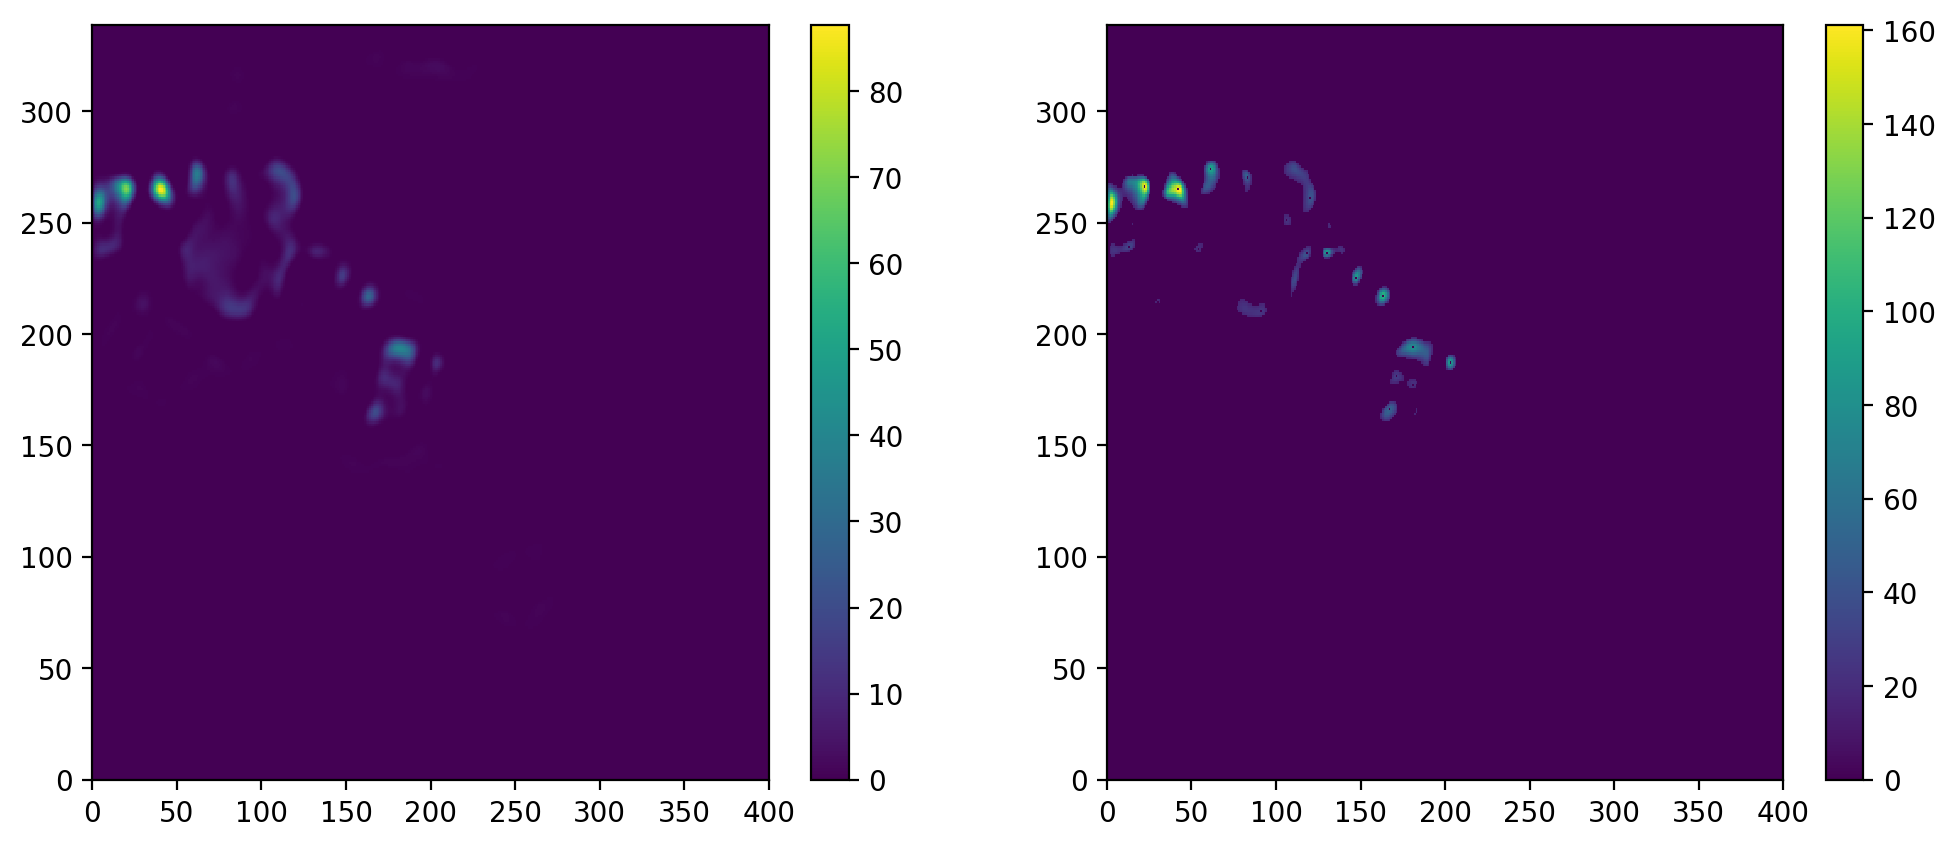

In [79]:
f = plt.figure(figsize=(12,5), dpi=200)
ax = f.add_subplot(121)
plt.pcolormesh(wObj.power[2,:,:], vmin=0)
plt.colorbar()
ax = f.add_subplot(122)
plt.pcolormesh(old_nflics5k, vmin=0)
plt.colorbar()

In [80]:
v5knflics = wObj.scaleWeighting(wtype='nflics', data_tag='MSG')

Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting


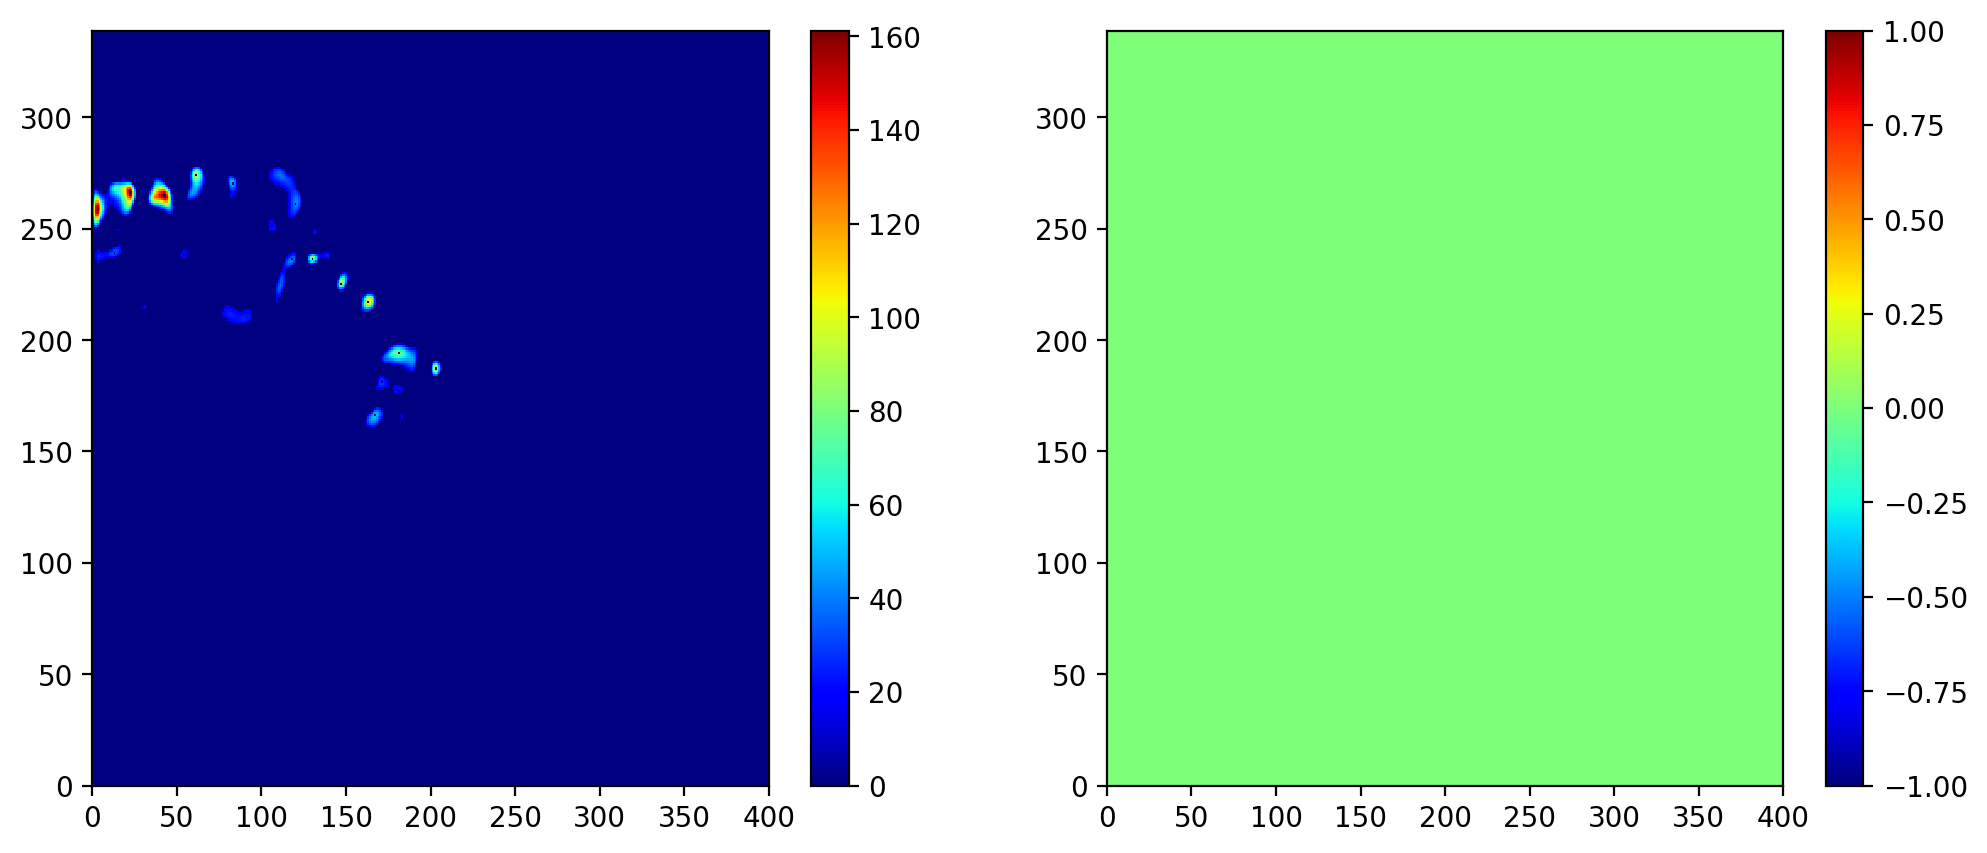

In [81]:
f = plt.figure(figsize=(12,5), dpi=200)
ax = f.add_subplot(121)
plt.pcolormesh(v5knflics, cmap='jet', vmin=0)
plt.colorbar()
ax = f.add_subplot(122)
plt.pcolormesh(old_nflics5k-v5knflics, cmap='jet', vmin=-1, vmax=1)
plt.colorbar()

In [18]:
#ss = wObj.to_dataarray(filepath ='/home/ck/DIR/cornkle/MCSfiles/MSG_cores/text.nc')

In [19]:
#print(ss)

In [20]:
#v5knflicsv2 = wObj.scaleWeighting(wtype='nflicsv2')

In [21]:
#plt.pcolormesh(v5knflicsv2, vmin=0)

In [22]:
wObj.scales

array([ 25.        ,  35.35533906,  50.        ,  70.71067812,
       100.        ])

In [23]:
wObj2 = cores.dataset('METEOSAT3K_veraLS')
wObj2.read_img(orig3k, lon3k, lat3k, edge_smoothing=False)
wObj2.applyWavelet(normed='scales')
v3knflicsv2 = wObj2.scaleWeighting(wtype='nflicsv2')#', data_tag='MSG') # nflicsv2

Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021]
outmin -86.45721612848634 0.0
Wavelet coefficients and power normed by: scales Possible tags: "scale", "stddev"


In [24]:
#ss = wObj2.to_dataarray(filepath ='/home/ck/DIR/cornkle/MCSfiles/MSG_cores/text.nc')

In [25]:
#out = xr.open_dataset('/home/ck/DIR/cornkle/MCSfiles/MSG_cores/text.nc')

In [26]:
#v3knflicsv2 = out['power'].values

In [27]:
#out

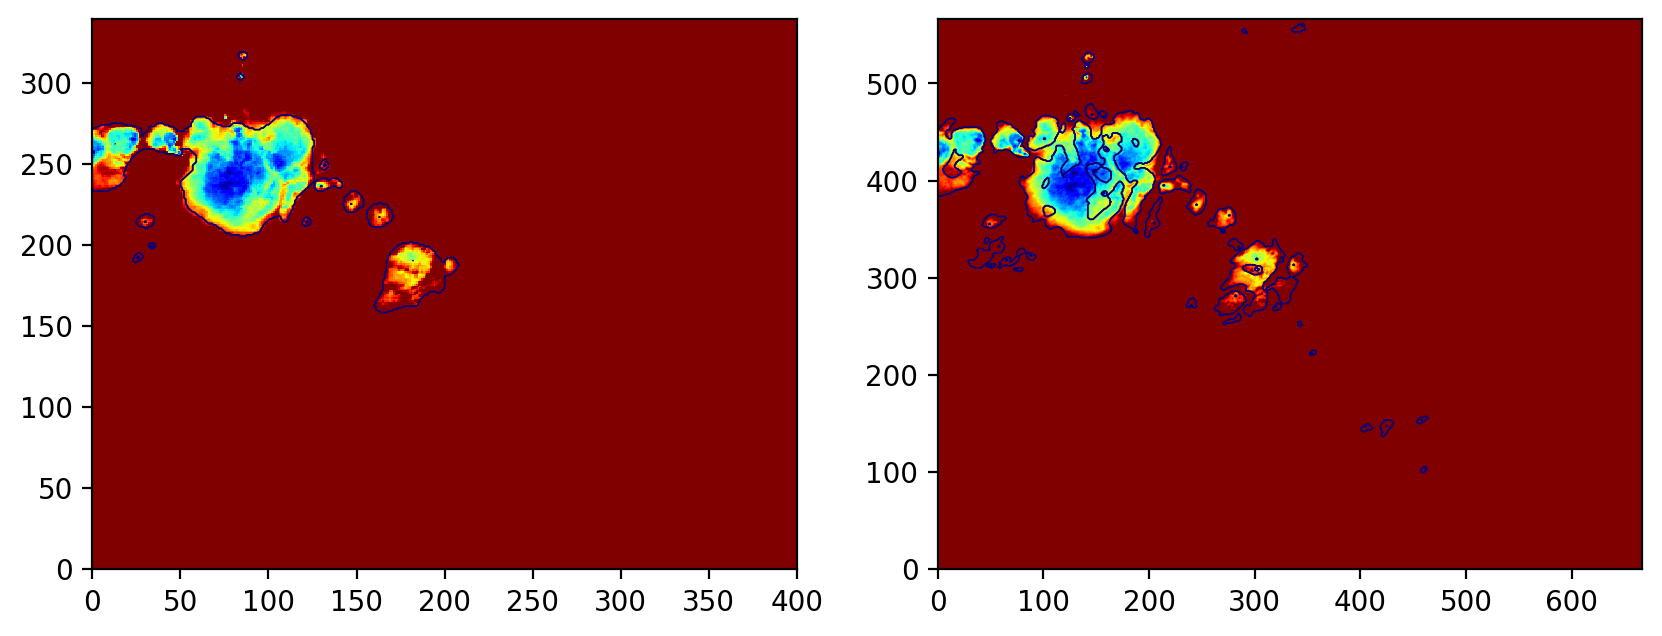

In [28]:
f = plt.figure(figsize=(10,8), dpi=200)
ax = f.add_subplot(221)

# plt.pcolormesh(wObj.image, vmax=-65, vmin=-85, cmap='jet')
# plt.contour(old_nflics5k, levels=[0,1], cmap='jet_r', linewidths=0.6)

plt.pcolormesh(wObj.image, vmax=-65, vmin=-85, cmap='jet')
plt.contour(v5knflics, levels=[0,1], cmap='jet_r', linewidths=0.6)

ax = f.add_subplot(222)
plt.pcolormesh(wObj2.image, vmax=-65, vmin=-85, cmap='jet')
plt.contour(v3knflicsv2, levels=[0,1], cmap='jet_r', linewidths=0.6)

# ax = f.add_subplot(223)
# plt.pcolormesh(np.array(old_nflics5k>0).astype(int)-np.array(v5knflics>0).astype(int), cmap='jet', vmin=-0.05, vmax=0.05)  #old_nflics5k   ,   v5knflicsv2

# plt.colorbar()
# ax = f.add_subplot(224)
# plt.pcolormesh(np.array(v3knflicsv2<0).astype(int)-np.array(old_nflics3k<0).astype(int), cmap='jet', vmin=-0.05, vmax=0.05)
# plt.colorbar()

In [255]:
prcp = xr.open_dataset(glob.glob('/media/ck/LStorage/NFLICS/GPM/2020/09/3B-HHR.MS.MRG.3IMERG.20200905*.1410.V06B*')[0])  #, group='/Grid/'
prcp = prcp['precipitationCal'].squeeze()
# pbox = prcp.sel(lat=slice(np.min(latitudes), np.max(latitudes)), lon=slice(np.min(longitudes),np.max(longitudes)))
prcp = prcp.sel(lon=slice(-19,0), lat=slice(4,18.5))

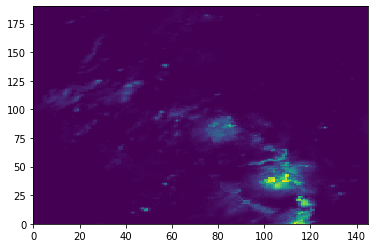

In [256]:
plt.pcolormesh(prcp, vmin=0)

In [257]:
prcp

<xarray.DataArray 'precipitationCal' (lon: 190, lat: 145)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * lat      (lat) float32 4.05 4.15 4.25 4.35 4.45 ... 18.15 18.25 18.35 18.45
  * lon      (lon) float32 -18.95 -18.85 -18.75 -18.65 ... -0.25 -0.15 -0.05
    time     object 2020-09-05 23:30:00
Attributes:
    DimensionNames:    time,lon,lat
    Units:             mm/hr
    units:             mm/hr
    CodeMissingValue:  -9999.9
    origname:          precipitationCal
    fullnamepath:      /Grid/precipitationCal
    coordinates:       Grid_time Grid_lon Grid_lat

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: linewidths is ignored by contourf
  if sys.path[0] == '':


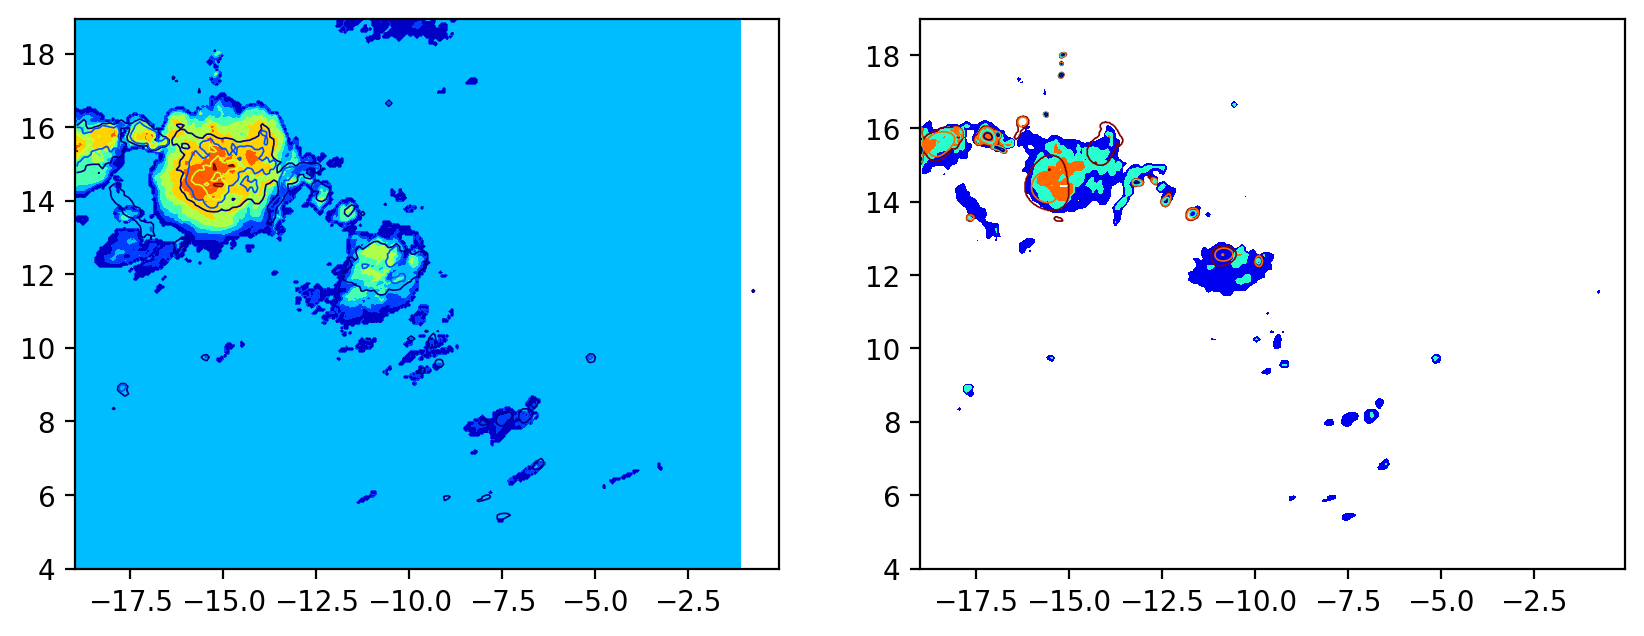

In [258]:
f = plt.figure(figsize=(10,8), dpi=200)
ax = f.add_subplot(221)

plt.contourf(lon5k, lat5k, wObj.image, cmap='jet_r')
plt.contour(prcp.lon, prcp.lat, prcp.T, cmap='jet', linewidths=0.6, levels=[5,10,20,30])

ax = f.add_subplot(222)
# plt.pcolormesh(wObj2.image, vmax=-65, vmin=-85, cmap='jet')
# plt.contour(v3knflicsv2, levels=[0,1], cmap='jet_r', linewidths=0.6)

#plt.contourf(lon5k, lat5k, wObj.image, cmap='jet')
plt.contourf(prcp.lon, prcp.lat, prcp.T, cmap='jet', linewidths=0.6, levels=[5,10,20,30])
plt.contour(lon3k, lat3k, v3knflicsv2, cmap='jet_r', linewidths=0.6, levels=[5,10,20,30])

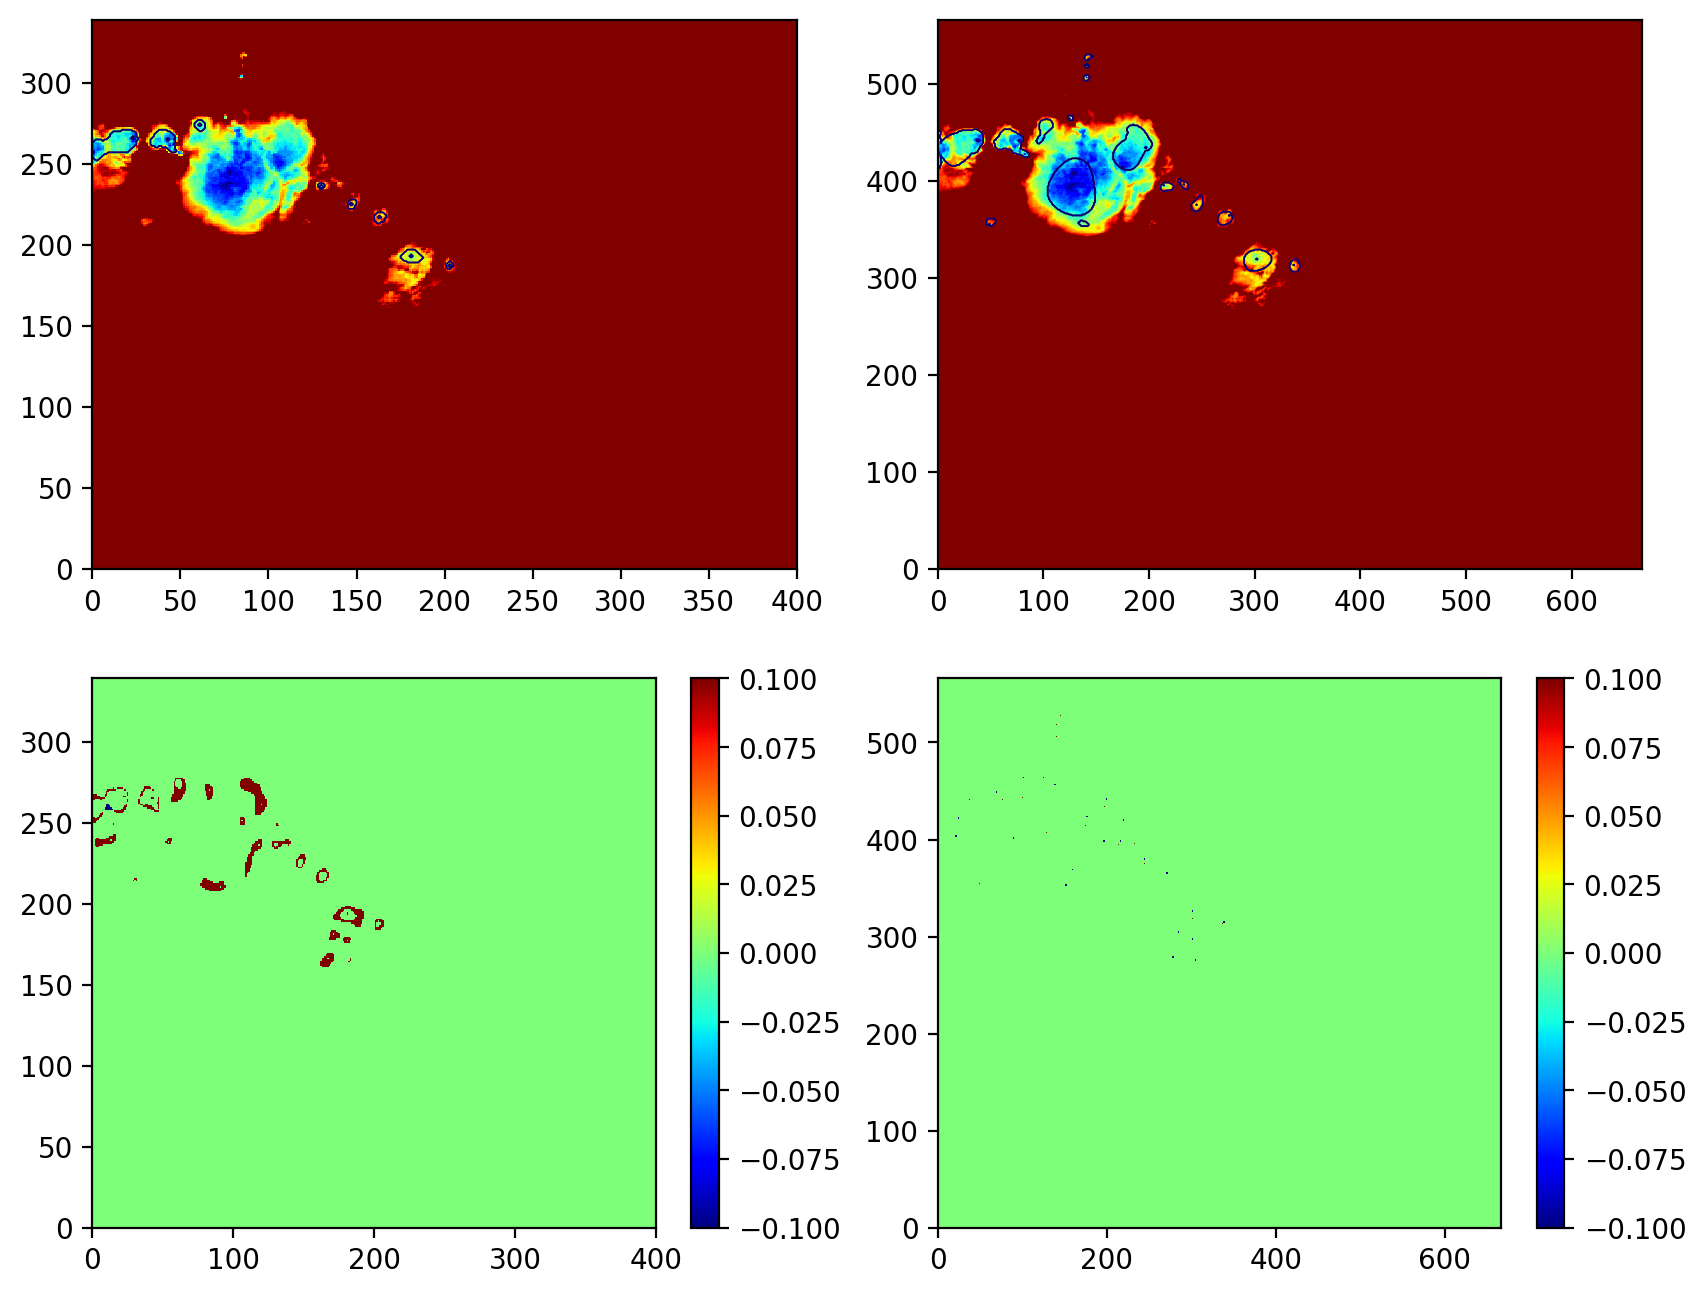

In [259]:
f = plt.figure(figsize=(10,8), dpi=200)
ax = f.add_subplot(221)

plt.pcolormesh(wObj.image, vmax=-65, vmin=-85, cmap='jet')
plt.contour(v5knflics, levels=[0,1], cmap='jet_r', linewidths=0.6)

ax = f.add_subplot(222)
plt.pcolormesh(wObj2.image, vmax=-65, vmin=-85, cmap='jet')
plt.contour(v3knflicsv2, levels=[0,1], cmap='jet_r', linewidths=0.6)

ax = f.add_subplot(223)
plt.pcolormesh(np.array(old_nflics5k>0).astype(int)-np.array(v5knflics>0).astype(int), cmap='jet', vmin=-0.1, vmax=0.1)  #old_nflics5k   ,   v5knflicsv2

plt.colorbar()
ax = f.add_subplot(224)
plt.pcolormesh(np.array(v3knflicsv2<0).astype(int)-np.array(old_nflics3k<0).astype(int), cmap='jet', vmin=-0.1, vmax=0.1)
plt.colorbar()

In [181]:
wObj3 = cores.dataset('METEOSAT3K_veraLS')
wObj3.read_img(orig3k, lon3k, lat3k, edge_smoothing=False)
wObj3.applyWavelet()
v3kdominant = wObj3.scaleWeighting(wtype='dominant')#', data_tag='MSG')

Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
outmin -86.45721612848634 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
9.0
13.0
18.0
24.0
34.0
48.0
66.0
92.0
129.0


NameError: name 'v3kindi' is not defined

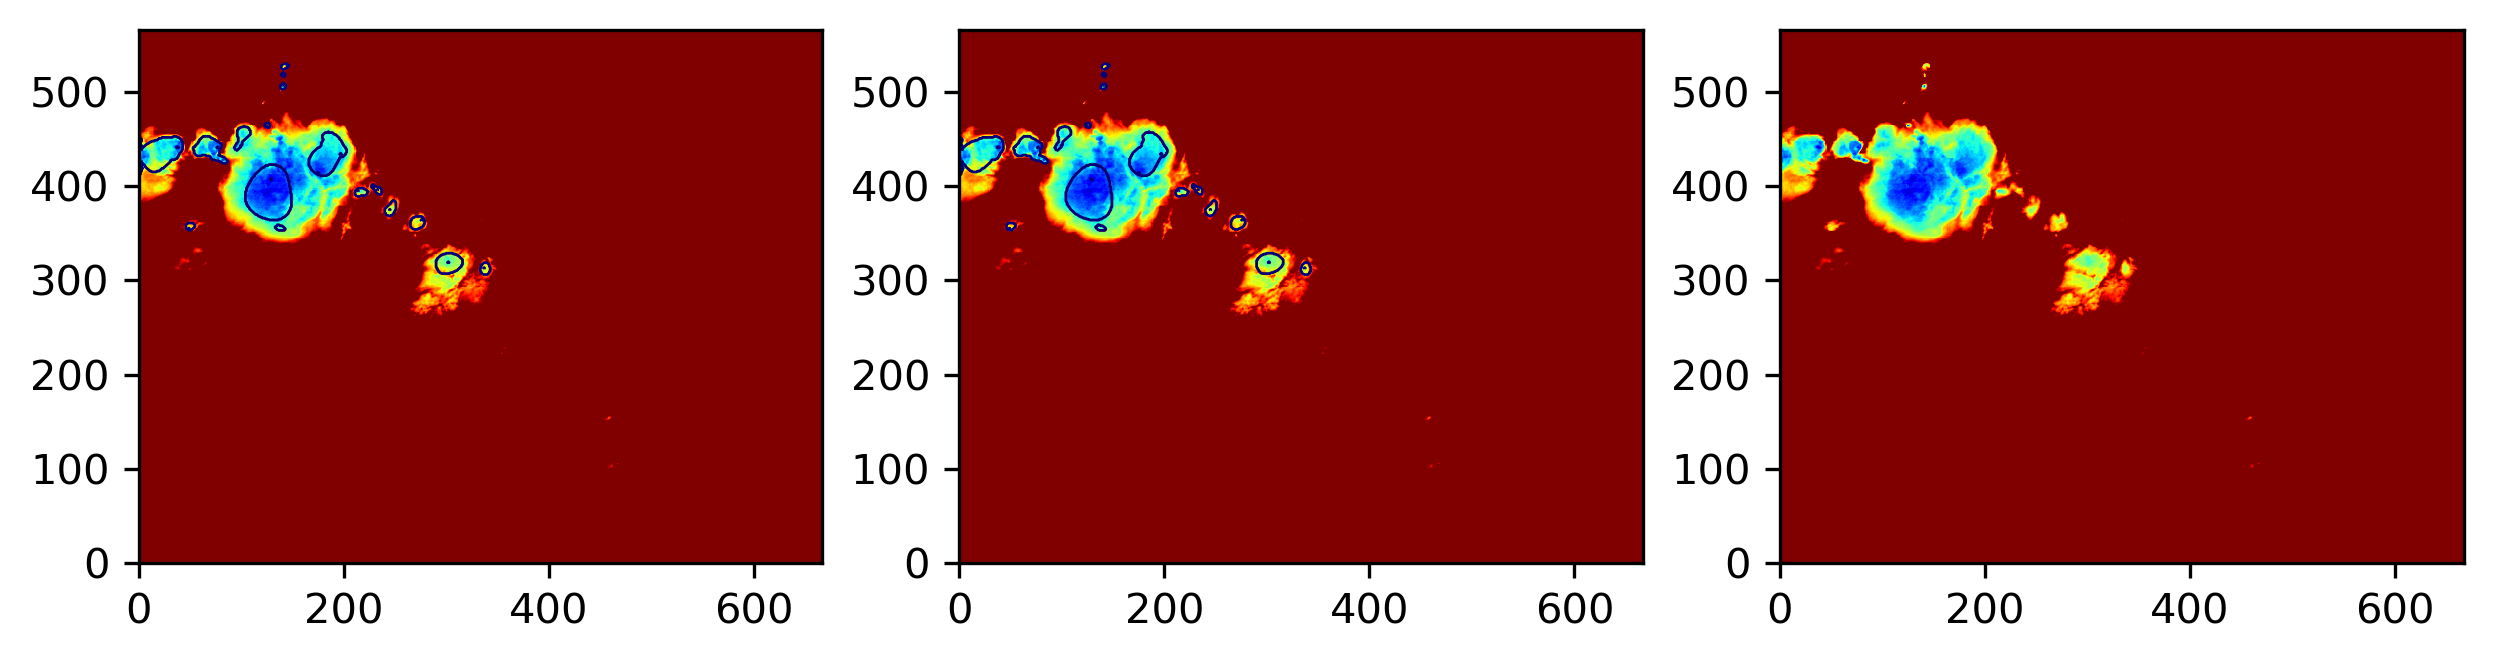

In [183]:
f = plt.figure(figsize=(10,8), dpi=300)
ax = f.add_subplot(331)
plt.pcolormesh(wObj2.image, vmax=-60, cmap='jet')
plt.contour(v3knflicsv2, levels=[0,1], cmap='jet_r', linewidths=0.6)

ax = f.add_subplot(332)
plt.contour(v3kdominant, levels=[0,1], cmap='jet_r', linewidths=0.6)
plt.pcolormesh(wObj2.image, vmax=-60, cmap='jet')

ax = f.add_subplot(333)
plt.pcolormesh(wObj2.image, vmax=-60, cmap='jet')
plt.contour(np.sum(v3kindi[0:2,:,:], axis=0), levels=[0,1], cmap='jet_r', linewidths=0.6) #np.sum(v3kindi, axis=0)


ax = f.add_subplot(334)
plt.pcolormesh(np.array(v3knflicsv2>0).astype(int)-np.array(old_nflics3k>0).astype(int), cmap='jet', vmin=-0.1, vmax=0.1)

plt.colorbar()
ax = f.add_subplot(335)
plt.pcolormesh(np.array(v3kdominant>0).astype(int)-np.array(old_nflics3k>0).astype(int), cmap='jet', vmin=-0.1, vmax=0.1)
plt.colorbar()

ax = f.add_subplot(336)
plt.pcolormesh(np.array(np.sum(v3kindi, axis=0)>0).astype(int)-np.array(old_nflics3k>0).astype(int), cmap='jet', vmin=-0.1, vmax=0.1)

In [ ]:
wObj3 = cores.dataset('METEOSAT3K_veraLS')
wObj3.read_img(orig3k, lon3k, lat3k, edge_smoothing=False)
wObj3.applyWavelet()
v3kindi = wObj3.scaleWeighting(wtype='ind')#', data_tag='MSG')

In [ ]:
f = plt.figure(figsize=(10,8), dpi=200)
ax = f.add_subplot(221)
plt.pcolormesh(wObj2.image, vmax=-60, cmap='jet')
plt.contour(v3kindi[1,:,:], levels=[0,1], cmap='jet_r', linewidths=0.6) #np.sum(v3kindi, axis=0)

ax = f.add_subplot(222)
plt.contour(v3kdominant, levels=[0,1], cmap='jet_r', linewidths=0.6)
plt.pcolormesh(wObj2.image, vmax=-60, cmap='jet')


ax = f.add_subplot(223)
plt.pcolormesh(np.array(np.sum(v3kindi, axis=0)>0).astype(int)-np.array(old_nflics3k>0).astype(int), cmap='jet', vmin=-0.1, vmax=0.1)

plt.colorbar()
ax = f.add_subplot(224)
plt.pcolormesh(np.array(v3kdominant>0).astype(int)-np.array(old_nflics3k>0).astype(int), cmap='jet', vmin=-0.1, vmax=0.1)
plt.colorbar()

In [ ]:
plt.hist(v3kindi[1,:,:][v3kindi[1,:,:]>0.1])